<a href="https://colab.research.google.com/github/dobrotvorn/DataCon23/blob/main/Mini_task3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Описание задания**
# Часть 1. Работа с данными

1) Просмотреть датасет на наличие выбросов и неверных данных

2) Разобраться в графиках из бейзлайна

3) Построить свои графики и выдвинуть по ним гипотезы

4) Отталкиваясь от этого, добавить некоторое количество новых дескрипторов при помощи rdkit (главное разобраться в коде, который это делает)

# Часть 2. Построение моделей

1) Построить свои модели на основе базовых регрессий из scikit-learn (минимум: обойти бейзлайн и попробовать хотя бы 3-4 модели
отличные от него)

2) Попробовать поработать с изменением параметров моделей и изменить соотношение тестовой/тренировочной выборки

3) Вывести графики feature importance полученных моделей

# Часть 3. Tensorflow

1) Провести эксперименты с архитектурами: количество слоев; функции активации; добавление дроп-аута/нормализации



## **Загрузка данных и библиотек**
# Импортируем и скачиваем библиотеки

In [234]:
!pip install gdown -- quiet
!pip install fancyimpute --quiet
import pandas as pd
import numpy as np
import gdown
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import plotly
import scipy.stats as stats
from sklearn.experimental import enable_iterative_imputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import IterativeImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import KNNImputer
from IPython.display import display, HTML
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from fancyimpute import KNN

ERROR: Could not find a version that satisfies the requirement quiet (from versions: none)
ERROR: No matching distribution found for quiet


In [235]:
# тут захардкодим статичные переменные
global ordinal_encoder
global text_columns
global path2firstDb
global numerics
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
path2firstDb = '/content/firstDb.csv' if 'google.colab' in sys.modules else 'firstDb.csv'

# Скачиваем данные

In [236]:
url1 = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vR7whTOZIO16kGSfmtP3zHyXoRog0r6LVk_UZjpIhHwiRocAL5SIiqUyoBfpFXqe1fnyDsIOhTc7cjM/pub?gid=139006229&single=true&output=csv'
output1 = 'firstDb.csv'
gdown.download(url1, output1, quiet=True)

/usr/local/lib/python3.10/dist-packages/gdown/parse_url.py:35: UserWarning: You specified a Google Drive link that is not the correct link to download a file. You might want to try `--fuzzy` option or the following url: https://drive.google.com/uc?id=None
  warnings.warn(


'firstDb.csv'

## **Часть 1. Работа с ДС**

**Описание параметров:**

SMILES - Представление молекулы в текстовом формате smiles.

Solubility - Растворимость вещества в воде.

MolLogP - десятичный логарифм коэффициента разделения.

MolMR -  Относительный молекулярный вес соединения.

HeavyAtomCount - Количество атомов не-водорода в молекуле.

NumRotatableBonds - Число поворотных связей в молекуле.

NumValenceElectrons - Количество  валентных электронов в соединении.

NumAromaticRings - Количество ароматических колец в молекуле.

TPSA - Топологическая площадь поверхности полярных атомов в соединении.

LabuteASA - площадь поверхности молекулы, доступная для взаимодействия с молекулами растворителя.

BertzCT - Индекс, предназначенный для количественной оценки “сложности” молекул.

MolWt - Молекулярный вес соединения.


In [237]:
fdb = pd.read_csv(path2firstDb)
fdb.head(7)
fdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9982 entries, 0 to 9981
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   SMILES               9982 non-null   object 
 1   Solubility           9897 non-null   float64
 2   MolLogP              9924 non-null   float64
 3   MolMR                9915 non-null   float64
 4   HeavyAtomCount       9959 non-null   float64
 5   NumRotatableBonds    9974 non-null   float64
 6   NumValenceElectrons  9917 non-null   float64
 7   NumAromaticRings     9936 non-null   float64
 8   TPSA                 9939 non-null   float64
 9   LabuteASA            9917 non-null   float64
 10  BertzCT              9945 non-null   float64
dtypes: float64(10), object(1)
memory usage: 858.0+ KB


# Исключение выбросов

SMILES - 0%
Solubility - 1%
MolLogP - 1%
MolMR - 1%
HeavyAtomCount - 0%
NumRotatableBonds - 0%
NumValenceElectrons - 1%
NumAromaticRings - 0%
TPSA - 0%
LabuteASA - 1%
BertzCT - 0%


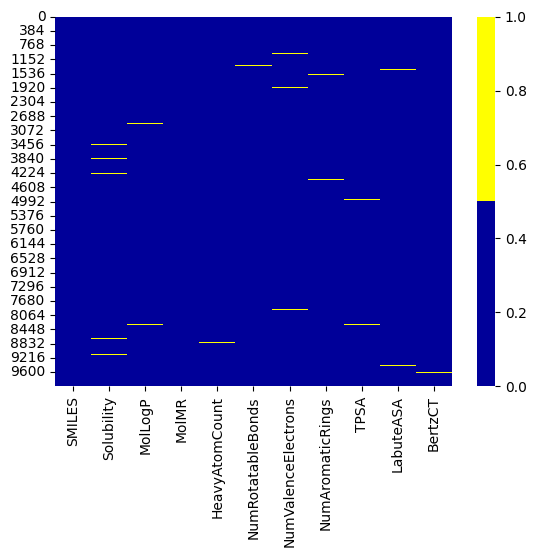

In [238]:
cols = fdb.columns
# желтый - пропущенные данные, синий - не пропущенные
colours = ['#000099', '#ffff00']
sns.heatmap(fdb[cols].isnull(), cmap=sns.color_palette(colours))
# процентный список пропущенных данных
for col in fdb.columns:
    pct_missing = np.mean(fdb[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

In [239]:
# Проверка на дубликаты по SMILES
df_dedupped = fdb.drop_duplicates(subset='SMILES')
print(fdb.shape)
print(df_dedupped.shape)
# Дубликаты отсутствуют

(9982, 11)
(9963, 10)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 9963 entries, 0 to 9981
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Solubility           9878 non-null   float64
 1   MolLogP              9905 non-null   float64
 2   MolMR                9896 non-null   float64
 3   HeavyAtomCount       9940 non-null   float64
 4   NumRotatableBonds    9955 non-null   float64
 5   NumValenceElectrons  9898 non-null   float64
 6   NumAromaticRings     9917 non-null   float64
 7   TPSA                 9920 non-null   float64
 8   LabuteASA            9898 non-null   float64
 9   BertzCT              9926 non-null   float64
dtypes: float64(10)
memory usage: 856.2 KB


In [240]:
# Меняет значения выше четырёх медианных абсолютных отклонений (Фильтр Хэмпеля)
def hampel(vals_orig):
    vals = vals_orig.copy()
    difference = np.abs(vals.median()-vals)
    median_abs_deviation = difference.median()
    threshold = 4 * median_abs_deviation
    outlier_idx = difference > threshold
    vals[outlier_idx] = np.nan
    return(vals)

In [241]:
def quart(vals_orig):
  vals = vals_orig.copy()
  Q1 = vals.quantile(q=.25)
  Q3 = vals.quantile(q=.75)
  IQR = vals.apply(stats.iqr)

  #only keep rows in dataframe that have values within 1.5\IQR of Q1 and Q3

  data_clean = vals[~((vals < (Q1-1.5*IQR)) | (vals > (Q3+1.5*IQR))).any(axis=1)]

  return(data_clean)
fdb = fdb.loc[:, 'Solubility':]
#fdb = quart(fdb)
Q1 = fdb.quantile(q=.25)
Q3 = fdb.quantile(q=.75)
IQR = fdb.apply(stats.iqr)

#only keep rows in dataframe that have values within 1.5\*IQR of Q1 and Q3
data_clean = fdb[~((fdb < (Q1-1.5*IQR)) | (fdb > (Q3+1.5*IQR))).any(axis=1)]

#find how many rows are left in the dataframe
data_clean.shape
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9982 entries, 0 to 9981
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Solubility           9897 non-null   float64
 1   MolLogP              9924 non-null   float64
 2   MolMR                9915 non-null   float64
 3   HeavyAtomCount       9959 non-null   float64
 4   NumRotatableBonds    9974 non-null   float64
 5   NumValenceElectrons  9917 non-null   float64
 6   NumAromaticRings     9936 non-null   float64
 7   TPSA                 9939 non-null   float64
 8   LabuteASA            9917 non-null   float64
 9   BertzCT              9945 non-null   float64
dtypes: float64(10)
memory usage: 857.8 KB


In [242]:
fdb = hampel(fdb)
fdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9982 entries, 0 to 9981
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Solubility           9760 non-null   float64
 1   MolLogP              9107 non-null   float64
 2   MolMR                9287 non-null   float64
 3   HeavyAtomCount       9280 non-null   float64
 4   NumRotatableBonds    9205 non-null   float64
 5   NumValenceElectrons  9232 non-null   float64
 6   NumAromaticRings     9682 non-null   float64
 7   TPSA                 9336 non-null   float64
 8   LabuteASA            9228 non-null   float64
 9   BertzCT              9339 non-null   float64
dtypes: float64(10)
memory usage: 780.0 KB
